# 1. Project setup

In [3]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np
import itertools

#Display every call in output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Visualization tools
import seaborn as sns
sns.set(style='whitegrid', palette='pastel', color_codes=True) 
sns.mpl.rc('figure', figsize=(20,20))
import matplotlib.pyplot as plt
%matplotlib inline

# Spatial weights matrix
from libpysal.weights.contiguity import Queen
from pysal.model import spreg
from pysal.lib import weights
# from pysal.explore import esda

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\envs\spatial_analysis\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\ProgramData\Anaconda3\envs\spatial_analysis\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# 2. Read dataset

In [4]:
# Read the dataset consisting of socio-economic and Covid-related data in Romania
ro_vaccines_incidence_socioec = pd.read_csv(os.path.join('data', 'ro_vaccines_incidence_socioec.csv'))
ro_vaccines_incidence_socioec.shape
ro_vaccines_incidence_socioec.head(2)

(3181, 47)

,siruta,Maximum Covid 19 Incidence Rate 3rd Wave,population,Vaccination Dose 1 26.05.2021,Vaccination Rate 26.05.2021,County,Administrative Territorial Unit,Vaccination Rate 05.10.2021,Vaccination Dose 1 05.10.2021,Covid 19 Incidence Rate 20.10.2021,...,Employees by rezidece from Active Population 2018 (%),Neoprotestants from Population 2011 (%),Migration experience,Gravity distances on the roads (in minutes) regional cut,The distanes until fist city of 200mii+ (ln),Core city,Peri-urban City,Peri-urban Village,Village,Size 100T+
0,153400.0,2.45,2470.0,159,6.44,Teleorman,Năsturelu,8.70,215.0,3.72,...,0.067922,0.0038,33.392919,0.472584,4.596129,0,0,1,0,0
1,152314.0,2.76,1846.0,128,6.93,Teleorman,Bujoru,8.99,166.0,6.11,...,0.055666,0.0488,30.498662,0.475430,4.486387,0,0,0,1,0


In [5]:
# Read the shapefile with all Romania's ATUs
ro_atu = gpd.read_file(os.path.join('data', 'ro_atu.shp'))
ro_atu.shape
ro_atu.head(2)

(3181, 2)

,siruta,geometry
0,153400.0,"POLYGON ((539844.121 245021.402, 539842.417 24..."
1,152314.0,"MULTIPOLYGON (((542412.565 245177.694, 542581...."


In [6]:
# Merge the two frames into a single geoadtaframe 
ro_atu_vaccines_incidence_socioec = ro_atu.merge(ro_vaccines_incidence_socioec, on='siruta')
ro_atu_vaccines_incidence_socioec.shape
ro_atu_vaccines_incidence_socioec.head(2)

(3181, 48)

,siruta,geometry,Maximum Covid 19 Incidence Rate 3rd Wave,population,Vaccination Dose 1 26.05.2021,Vaccination Rate 26.05.2021,County,Administrative Territorial Unit,Vaccination Rate 05.10.2021,Vaccination Dose 1 05.10.2021,...,Employees by rezidece from Active Population 2018 (%),Neoprotestants from Population 2011 (%),Migration experience,Gravity distances on the roads (in minutes) regional cut,The distanes until fist city of 200mii+ (ln),Core city,Peri-urban City,Peri-urban Village,Village,Size 100T+
0,153400.0,"POLYGON ((539844.121 245021.402, 539842.417 24...",2.45,2470.0,159,6.44,Teleorman,Năsturelu,8.70,215.0,...,0.067922,0.0038,33.392919,0.472584,4.596129,0,0,1,0,0
1,152314.0,"MULTIPOLYGON (((542412.565 245177.694, 542581....",2.76,1846.0,128,6.93,Teleorman,Bujoru,8.99,166.0,...,0.055666,0.0488,30.498662,0.475430,4.486387,0,0,0,1,0


## Analyze the dataset

In [5]:
# Descriptive statistics
ro_atu_vaccines_incidence_socioec.describe()

,siruta,Maximum Covid 19 Incidence Rate 3rd Wave,population,Vaccination Dose 1 26.05.2021,Vaccination Rate 26.05.2021,Vaccination Rate 05.10.2021,Vaccination Dose 1 05.10.2021,Covid 19 Incidence Rate 20.10.2021,Industrial growing labour market 2011-2018 (dummy),Services growing labour market 2011-2018 (dummy),...,Employees by rezidece from Active Population 2018 (%),Neoprotestants from Population 2011 (%),Migration experience,Gravity distances on the roads (in minutes) regional cut,The distanes until fist city of 200mii+ (ln),Core city,Peri-urban City,Peri-urban Village,Village,Size 100T+
count,3181.000000,3181.000000,3.181000e+03,3181.000000,3181.000000,3181.000000,3179.000000,3181.000000,3181.000000,3181.000000,...,3181.000000,3181.000000,3181.000000,3181.000000,3181.000000,3181.000000,3181.000000,3181.000000,3181.000000,3181.000000
mean,94797.463062,1.966675,6.969601e+03,1294.948130,10.976809,16.424558,1710.955017,5.229948,0.309965,0.175417,...,0.157167,0.038616,47.655545,0.523014,4.151938,0.081735,0.018548,0.398931,0.500786,0.007545
std,50664.661840,1.938553,4.297404e+04,12731.491989,6.067728,7.249309,16238.912539,3.708775,0.462552,0.380383,...,0.156644,0.060752,15.886100,0.066775,0.589067,0.274004,0.134942,0.489756,0.500078,0.086546
min,1017.000000,0.000000,1.210000e+02,8.000000,0.180000,0.390000,12.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,17.575164,0.000000,1.504077,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51699.000000,0.630000,2.029000e+03,156.000000,6.590000,11.240000,263.000000,2.560000,0.000000,0.000000,...,0.068354,0.003100,37.208122,0.493100,3.850148,0.000000,0.000000,0.000000,0.000000,0.000000
50%,96593.000000,1.420000,3.061000e+03,273.000000,9.600000,15.180000,433.000000,4.370000,0.000000,0.000000,...,0.104730,0.013700,47.948292,0.519358,4.287716,0.000000,0.000000,0.000000,1.000000,0.000000
75%,139330.000000,2.760000,4.910000e+03,502.000000,14.110000,20.470000,768.500000,7.020000,1.000000,0.000000,...,0.179443,0.049900,57.825580,0.553062,4.557030,0.000000,0.000000,1.000000,1.000000,0.000000
max,180091.000000,17.290000,2.151665e+06,644973.000000,44.260000,54.500000,829682.000000,33.330000,1.000000,1.000000,...,2.337310,0.612800,102.179676,0.937123,5.381739,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
plt = ro_atu_vaccines_incidence_socioec.plot(column=ro_atu_vaccines_incidence_socioec['Maximum Covid 19 Incidence Rate 3rd Wave'], scheme='Quantiles', k=5, cmap='Blues',  figsize=(5, 5), legend=True)

In [ ]:
plt = ro_atu_vaccines_incidence_socioec.plot(column=ro_atu_vaccines_incidence_socioec['Vaccination Rate 26.05.2021'], scheme='Quantiles', k=5, cmap='Blues',  figsize=(20, 20), edgecolor='gray',  linewidth=0.1, legend=True)

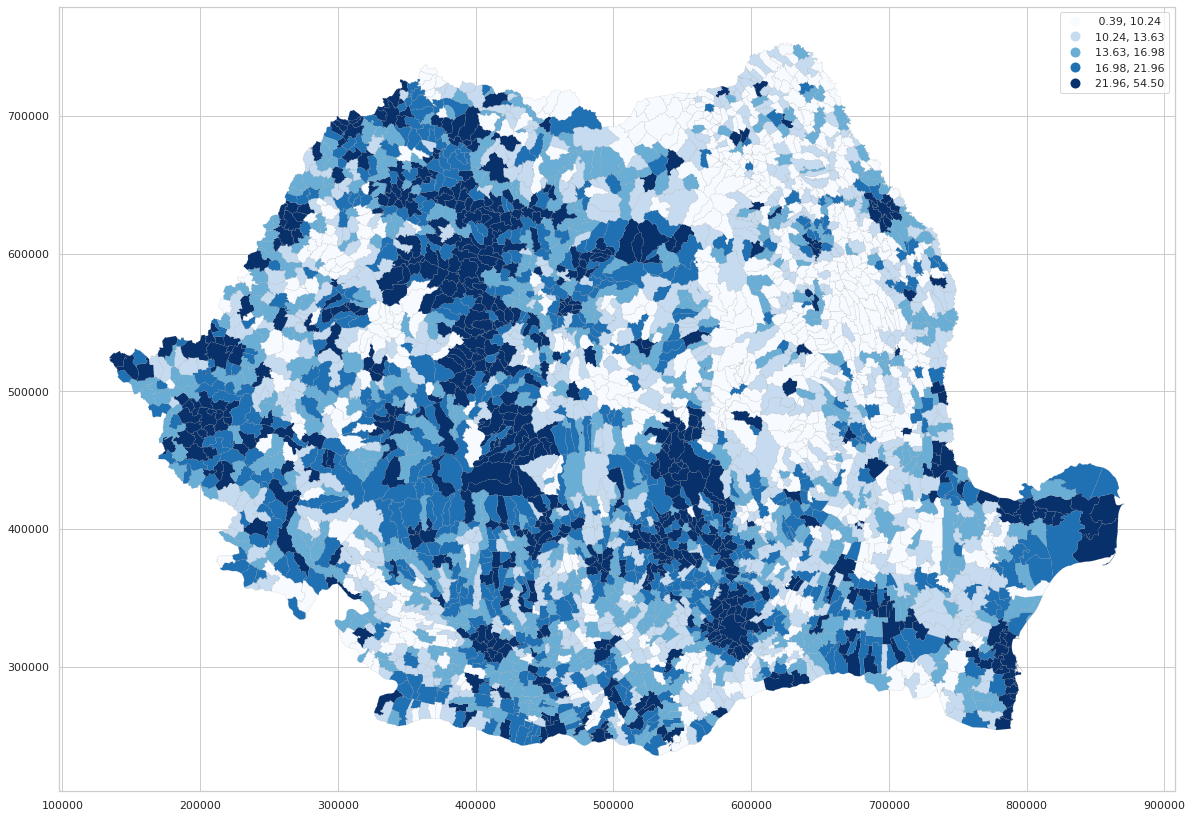

In [ ]:
plt = ro_atu_vaccines_incidence_socioec.plot(column=ro_atu_vaccines_incidence_socioec['Vaccination Rate 05.10.2021'], scheme='Quantiles', k=5, cmap='Blues',  figsize=(20, 20), edgecolor='gray',  linewidth=0.1, legend=True)

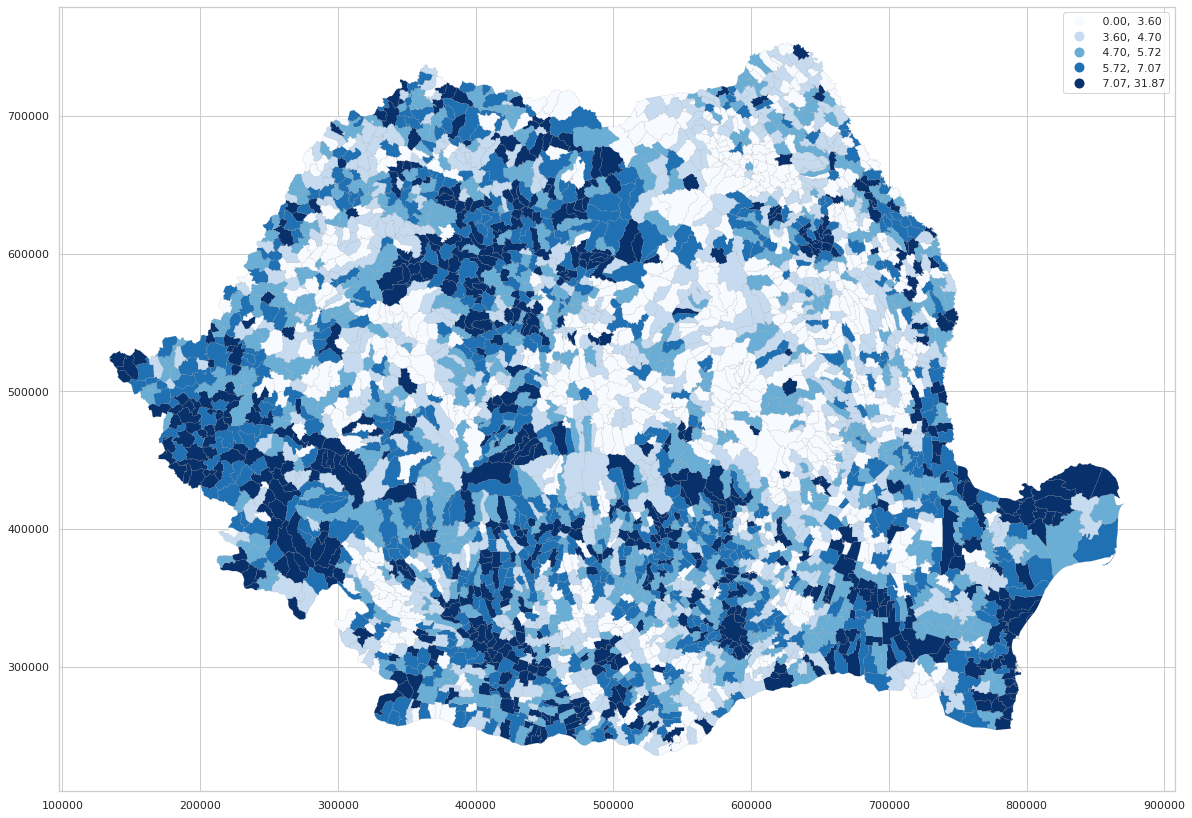

In [ ]:
plt = ro_atu_vaccines_incidence_socioec.plot(column=ro_atu_vaccines_incidence_socioec['Vaccination Rate 05.10.2021']-vaccines_incidence_hindex_more_var_gdf['Vaccination Rate 26.05.2021'], scheme='Quantiles', k=5, cmap='Blues',  figsize=(20, 20), edgecolor='gray',  linewidth=0.1, legend=True)

In [ ]:
# vaccines_incidence_hindex_more_var_gdf.to_file(os.path.join(shapefiles_data_path, 'vaccines_incidence_hindex_more_var_gdf.shp'))
# vaccines_incidence_hindex_more_var_gdf = gpd.read_file(os.path.join(shapefiles_data_path, 'vaccines_incidence_hindex_more_var_gdf.shp'))

In [8]:
ro_atu_vaccines_incidence_socioec.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3181 entries, 0 to 3180
Data columns (total 48 columns):
 #   Column                                                       Non-Null Count  Dtype   
---  ------                                                       --------------  -----   
 0   siruta                                                       3181 non-null   float64 
 1   geometry                                                     3181 non-null   geometry
 2   Maximum Covid 19 Incidence Rate 3rd Wave                     3181 non-null   float64 
 3   population                                                   3181 non-null   float64 
 4   Vaccination Dose 1 26.05.2021                                3181 non-null   int64   
 5   Vaccination Rate 26.05.2021                                  3181 non-null   float64 
 6   County                                                       3181 non-null   object  
 7   Administrative Territorial Unit                              

In [7]:
all_explanatory = ro_atu_vaccines_incidence_socioec.columns[15:]
all_explanatory = all_explanatory.to_list() + ['Maximum Covid 19 Incidence Rate 3rd Wave', 'Covid 19 Incidence Rate 20.10.2021']
all_explanatory

['Periurban locality (dummy)',
 'Employees by company from Active Population 2018 (%)',
 'Employees by rezidence from Active Population 2019 (%)',
 'School enrollment to young population 2018 (%)',
 'School enrollment to young population 2019 (%)',
 'Elderly (65+) 2018 (%)',
 'Elderly (65+) 2019 (%)',
 'Elderly (65+) 2020 (%)',
 'Primary education (4 grades) 2011 (%)',
 'Lower secondary education (8 grades) 2011 (%)',
 'Relative poverty 2016 (%)',
 'Voters present at the polls for the referendum 2018 (%)',
 'Votes cast for "YES" at the referendum 2018 (%)',
 'People pe sqkm 2018',
 'Living space per person 2018 (sqm)',
 'Living space per person 2019 (sqm)',
 'Living space per person 2020 (sqm)',
 'Distances on roads (average in km to all cities in Romania)',
 'Gravity distances on the roads (m & pop adj.)',
 'Gravity distances on the roads (m & pop adj.) regional cut',
 'Degrees Weighted Out (network road distances)',
 'Locality with public airports (dummy)',
 'Locality with commercial

In [9]:
all_explanatory_selected = [
 "Employees by rezidence from Active Population 2019 (%)",
 "Living space per person 2019 (sqm)",
 "Voters present at the polls for the referendum 2018 (%)",
 "Locality with public airports (dummy)",
 "Primary education (4 grades) 2011 (%)",
 "School enrollment to young population 2019 (%)",
 "Lower secondary education (8 grades) 2011 (%)",
 "Elderly (65+) 2019 (%)",
 "Relative poverty 2016 (%)",
 "Neoprotestants from Population 2011 (%)",
 "Migration experience",
 "Maximum Covid 19 Incidence Rate 3rd Wave",
 "The distanes until fist city of 200mii+ (ln)",
 "Core city",
 "Peri-urban City",
 "Peri-urban Village",
 "Size 100T+"
]

# 3. Model

In [7]:
# DEFINE SPATIAL MATRIX
w_q = Queen.from_dataframe(ro_atu_vaccines_incidence_socioec)
w_q.transform = 'r'

In [ ]:
tmp = w_q.plot(ro_atu_vaccines_incidence_socioec, node_kws=dict(marker='*', color='k'))

## Models with combinations (all combinations that yield less than 30)

Trying to find the best combination of variables in the model by reducing the multicolinearity

In [17]:
combinations = itertools.combinations(all_explanatory_selected, 14)

In [21]:
best_combinations = []
for combination in combinations:
    explanatory = list(combination)
    X = ro_atu_vaccines_incidence_socioec[all_explanatory_selected].values
    y = ro_atu_vaccines_incidence_socioec[['Vaccination Rate 26.05.2021']].values

    name_x = explanatory
    name_y = 'Vaccination Rate 26.05.2021'
    name_w = "Q row std"
    name_ds = 'ro_atu_vaccines_incidence_socioec'


    # OLS ROBUST WHITE
    m1_robust_white = spreg.OLS(y, X, w=w_q, spat_diag=True, white_test=True, moran=True, name_y=name_y, name_x=name_x, robust='white', name_w=name_w, name_ds=name_ds)
    if m1_robust_white.mulColli <= 30:
        print(combination)
        print(m1_robust_white.summary)
        best_combinations.append(combination)

Exception: w must be a pysal.lib.W object to run spatial diagnostics

In [12]:
best_combination_dist = ['Employees by rezidence from Active Population 2019 (%)', 
                         'Living space per person 2019 (sqm)',
                         'Voters present at the polls for the referendum 2018 (%)', 
                         'Locality with public airports (dummy)',
                         'Primary education (4 grades) 2011 (%)', 
                         'Elderly (65+) 2019 (%)', 
                         'Relative poverty 2016 (%)', 
                         'Neoprotestants from Population 2011 (%)', 
                         'Migration experience', 
                         'Maximum Covid 19 Incidence Rate 3rd Wave', 
                         'Core city', 
                         'Peri-urban City', 
                         'Peri-urban Village', 
                         'Size 100T+']

In [ ]:
# DEFINE X, Y
X = vaccines_incidence_hindex_more_var_gdf[best_combination_dist].values
y = vaccines_incidence_hindex_more_var_gdf[['Vaccination Rate 26.05.2021']].values

name_x = best_combination_dist
name_y = 'Vaccination Rate'
name_w = "Q row std"
name_ds = 'vaccines_incidence_socio_economic'

print('OLS WITH SPATIAL TESTS')
m1_robust_white = spreg.OLS(y, X, w=w_q, spat_diag=True, white_test=True, moran=True, name_y=name_y, name_x=name_x, robust='white', name_w=name_w, name_ds=name_ds)
print(m1_robust_white.summary)

print('GMM method for a spatial lag and error model with endogenous variables, with results and diagnostics; based on Kelejian and Prucha (1998, 1999) [KP98] [KP99].')
# COMBINED
m6 = spreg.GM_Combo(y, X, w=w_q, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
print(m6.summary)

print('GMM method for a spatial lag and error model with heteroskedasticity and endogenous variables, with results and diagnostics; based on [ADKP10], following [Ans11].')
m7 = spreg.GM_Combo_Het(y, X, w=w_q, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
print(m7.summary)

OLS WITH SPATIAL TESTS
REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :vaccines_incidence_socio_economic
Weights matrix      :   Q row std
Dependent Variable  :Vaccination Rate                Number of Observations:        3181
Mean dependent var  :     10.9768                Number of Variables   :          15
S.D. dependent var  :      6.0677                Degrees of Freedom    :        3166
R-squared           :      0.5789
Adjusted R-squared  :      0.5770
Sum squared residual:   49304.897                F-statistic           :    310.8546
Sigma-square        :      15.573                Prob(F-statistic)     :           0
S.E. of regression  :       3.946                Log likelihood        :   -8872.930
Sigma-square ML     :      15.500                Akaike info criterion :   17775.860
S.E of regression ML:      3.9370                Schwarz criterion     :   17866.834

White Standard Errors
-------

In [ ]:
best_combination_robust = ['Employees by rezidence from Active Population 2019 (%)', 'Living space per person 2019 (sqm)', 'Voters present at the polls for the referendum 2018 (%)', 'Locality with public airports (dummy)', 'School enrollment to young population 2019 (%)', 'Elderly (65+) 2019 (%)', 'Relative poverty 2016 (%)', 'Neoprotestants from Population 2011 (%)', 'Migration experience', 'Maximum Covid 19 Incidence Rate 3rd Wave', 'Core city', 'Peri-urban City', 'Peri-urban Village', 'Size 100T+']

In [ ]:
best_combination_robust

['Employees by rezidence from Active Population 2019 (%)',
 'Living space per person 2019 (sqm)',
 'Voters present at the polls for the referendum 2018 (%)',
 'Locality with public airports (dummy)',
 'School enrollment to young population 2019 (%)',
 'Elderly (65+) 2019 (%)',
 'Relative poverty 2016 (%)',
 'Neoprotestants from Population 2011 (%)',
 'Migration experience',
 'Maximum Covid 19 Incidence Rate 3rd Wave',
 'Core city',
 'Peri-urban City',
 'Peri-urban Village',
 'Size 100T+']

In [ ]:
best_combination_dist

['Employees by rezidence from Active Population 2019 (%)',
 'Living space per person 2019 (sqm)',
 'Voters present at the polls for the referendum 2018 (%)',
 'Locality with public airports (dummy)',
 'Primary education (4 grades) 2011 (%)',
 'Elderly (65+) 2019 (%)',
 'Relative poverty 2016 (%)',
 'Neoprotestants from Population 2011 (%)',
 'Migration experience',
 'Maximum Covid 19 Incidence Rate 3rd Wave',
 'Core city',
 'Peri-urban City',
 'Peri-urban Village',
 'Size 100T+']

In [ ]:
# DEFINE X, Y
X = vaccines_incidence_hindex_more_var_gdf[best_combination_robust].values
y = vaccines_incidence_hindex_more_var_gdf[['Vaccination Rate 26.05.2021']].values

name_x = best_combination_robust
name_y = 'Vaccination Rate'
name_w = "Q row std"
name_ds = 'vaccines_incidence_socio_economic'

print('GMM method for a spatial lag and error model with endogenous variables, with results and diagnostics; based on Kelejian and Prucha (1998, 1999) [KP98] [KP99].')
# COMBINED
m6 = spreg.GM_Combo(y, X, w=w_q, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
print(m6.summary)

print('GMM method for a spatial lag and error model with heteroskedasticity and endogenous variables, with results and diagnostics; based on [ADKP10], following [Ans11].')
m7 = spreg.GM_Combo_Het(y, X, w=w_q, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
print(m7.summary)

GMM method for a spatial lag and error model with endogenous variables, with results and diagnostics; based on Kelejian and Prucha (1998, 1999) [KP98] [KP99].
REGRESSION
----------
SUMMARY OF OUTPUT: SPATIALLY WEIGHTED TWO STAGE LEAST SQUARES
-------------------------------------------------------------
Data set            :vaccines_incidence_socio_economic
Weights matrix      :   Q row std
Dependent Variable  :Vaccination Rate                Number of Observations:        3181
Mean dependent var  :     10.9768                Number of Variables   :          16
S.D. dependent var  :      6.0677                Degrees of Freedom    :        3165
Pseudo R-squared    :      0.6999
Spatial Pseudo R-squared:  0.5594

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT   

In [ ]:
best_combination_newest = ['Employees by rezidence from Active Population 2019 (%)', 
                         'Living space per person 2019 (sqm)',
                         'Voters present at the polls for the referendum 2018 (%)', 
                         'Locality with public airports (dummy)',
                         'Primary education (4 grades) 2011 (%)', 
                         'Elderly (65+) 2019 (%)', 
                         'Relative poverty 2016 (%)', 
                         'Neoprotestants from Population 2011 (%)', 
                         'Migration experience', 
                         'Maximum Covid 19 Incidence Rate 3rd Wave', 
                         'Core city', 
                         'Peri-urban City', 
                         'Peri-urban Village', 
                         'Size 100T+']

In [ ]:
# DEFINE X, Y
X = vaccines_incidence_hindex_more_var_gdf[best_combination_newest].values
y = vaccines_incidence_hindex_more_var_gdf[['Vaccination Rate 05.10.2021']].values

name_x = best_combination_newest
name_y = 'Vaccination Rate'
name_w = "Q row std"
name_ds = 'vaccines_incidence_socio_economic'

# OLS ROBUST WHITE
m1 = spreg.OLS(y, X, w=w_q, spat_diag=True, white_test=True, moran=True, name_y=name_y, name_x=name_x, robust='white', name_w=name_w, name_ds=name_ds)
print(m1.summary)

print('GMM method for a spatial lag and error model with endogenous variables, with results and diagnostics; based on Kelejian and Prucha (1998, 1999) [KP98] [KP99].')
# COMBINED
m6 = spreg.GM_Combo(y, X, w=w_q, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
print(m6.summary)

print('GMM method for a spatial lag and error model with heteroskedasticity and endogenous variables, with results and diagnostics; based on [ADKP10], following [Ans11].')
m7 = spreg.GM_Combo_Het(y, X, w=w_q, name_y=name_y, name_x=name_x, name_w=name_w, name_ds=name_ds)
print(m7.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :vaccines_incidence_socio_economic
Weights matrix      :   Q row std
Dependent Variable  :Vaccination Rate                Number of Observations:        3181
Mean dependent var  :     16.4246                Number of Variables   :          15
S.D. dependent var  :      7.2493                Degrees of Freedom    :        3166
R-squared           :      0.5344
Adjusted R-squared  :      0.5324
Sum squared residual:   77804.275                F-statistic           :    259.5925
Sigma-square        :      24.575                Prob(F-statistic)     :           0
S.E. of regression  :       4.957                Log likelihood        :   -9598.473
Sigma-square ML     :      24.459                Akaike info criterion :   19226.946
S.E of regression ML:      4.9456                Schwarz criterion     :   19317.921

White Standard Errors
------------------------------